In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import datetime as dt
import time as tm
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

Data Read

In [2]:
station = pd.read_csv('station_data.csv')
trip = pd.read_csv('trip_data.csv')
weather = pd.read_csv('weather_data.csv')

In [3]:
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [12]:
c=['Start Station','End Station']
a=trip.where(trip[c]>50)[c]

a.head()

,Start Station,End Station
0,NaN,70.0
1,NaN,NaN
2,NaN,64.0
3,NaN,NaN
4,51.0,60.0


In [13]:
trip.iloc[1]['Trip ID']

913459

In [25]:
import random

random.uniform(1,1.2)


1.1590387131131392

# Data cleaning

### Weather Data Cleaning ###

In [3]:
citydict = {94107:'San Francisco',94063:'Redwood City',94301:'Palo Alto',94041:'Mountain View',95113:'San Jose'}
weather['City'] = weather['Zip'].map(citydict)
weather['Date'] = pd.to_datetime(weather['Date'])

In [4]:
# fill the empty weather value of the specific day & city combo with avg weather value from other cities
def fillinfo(emptycol):
    temp = weather[weather[emptycol].isna()]
    for date in temp['Date']:
        temp[emptycol][temp['Date'] == date] = weather[emptycol][weather['Date'] == date].mean()
    return temp

In [5]:
for col in weather.columns[1:21]:
    temp = fillinfo(col)
    weather[weather[col].isna()]=temp

weather[weather['WindDirDegrees'].isna()]=fillinfo('WindDirDegrees')

KeyboardInterrupt: 

In [ ]:
# for max gust speedMPH, every city miss value on specific days
# fill values with previous day average max gust speedMPH
temp = weather[weather['Max Gust SpeedMPH'].isna()]
for date in temp['Date']:
    dateminus1 = date-dt.timedelta(days = 1)
    temp['Max Gust SpeedMPH'][temp['Date'] == date] = weather['Max Gust SpeedMPH'][weather['Date']==dateminus1].mean()
weather[weather['Max Gust SpeedMPH'].isna()]=temp

In [8]:
# fill empty events with a new category 'No Event'
weather['Events'][weather['Events'].isna()] = 'No Event'

In [9]:
# confirm weather data is clean
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 25 columns):
Date                         1825 non-null datetime64[ns]
Max TemperatureF             1825 non-null float64
Mean TemperatureF            1825 non-null float64
Min TemperatureF             1825 non-null float64
Max Dew PointF               1825 non-null float64
MeanDew PointF               1825 non-null float64
Min DewpointF                1825 non-null float64
Max Humidity                 1825 non-null float64
Mean Humidity                1825 non-null float64
Min Humidity                 1825 non-null float64
Max Sea Level PressureIn     1825 non-null float64
Mean Sea Level PressureIn    1825 non-null float64
Min Sea Level PressureIn     1825 non-null float64
Max VisibilityMiles          1825 non-null float64
Mean VisibilityMiles         1825 non-null float64
Min VisibilityMiles          1825 non-null float64
Max Wind SpeedMPH            1825 non-null float64
Mean Wind SpeedMPH 

### Target Variable Construction ###

target variable = net rate of each station in each hour

1. deal with time 

In [10]:
#transfer time string to datetime 
def getintime(datetime_str):
    import time
    datetime= time.strptime(datetime_str, "%d/%m/%Y %H:%M")    
    return datetime.tm_year, datetime.tm_mon, datetime.tm_mday, datetime.tm_hour

In [11]:
def getouttime(datetime_str):
    import time
    datetime= time.strptime(datetime_str, "%d/%m/%Y %H:%M")    
    return datetime.tm_hour

In [19]:
dateset1 =[]
a = trip['End Date'].apply(getintime)

In [20]:
dateset1 = pd.DataFrame(list(a),columns = ['year','mon','day','inhour'])
dateset1.head()

,year,mon,day,inhour
0,2015,8,31,23
1,2015,8,31,23
2,2015,8,31,23
3,2015,8,31,23
4,2015,8,31,23


In [21]:
b=trip['Start Date'].apply(getouttime)

In [59]:
list(b)
dateset1['outhour']=list(b)
dateset1.head()

,year,mon,day,inhour,outhour
0,2015,8,31,23,23
1,2015,8,31,23,23
2,2015,8,31,23,23
3,2015,8,31,23,23
4,2015,8,31,23,23


In [60]:
# dateset2 : all information of each trip, including timedetailes
dateset2 = pd.concat([trip,dateset1],axis=1,sort=False)
dateset2.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,year,mon,day,inhour,outhour
0,913460,31/08/2015 23:26,San Francisco,31/08/2015 23:39,San Francisco,Subscriber,2015,8,31,23,23
1,913459,31/08/2015 23:11,Mountain View,31/08/2015 23:28,Mountain View,Subscriber,2015,8,31,23,23
2,913455,31/08/2015 23:13,San Francisco,31/08/2015 23:18,San Francisco,Subscriber,2015,8,31,23,23
3,913454,31/08/2015 23:10,San Jose,31/08/2015 23:17,San Jose,Subscriber,2015,8,31,23,23
4,913453,31/08/2015 23:09,San Francisco,31/08/2015 23:22,San Francisco,Customer,2015,8,31,23,23


Calculate Net rate 

In [72]:
# inhour : the time end station recieve bike
# outhour: the time start station lose bike
data1 = dateset2[['Trip ID','Start Station','Start Date','year','mon','day','outhour']]
data2 = dateset2[['Trip ID','End Station','End Date','year','mon','day','inhour']]


In [73]:
x=data1.groupby(['Start Station','year','mon','day','outhour']).count().reset_index()
x.head()

,Start Station,year,mon,day,outhour,Trip ID,Start Date
0,Mountain View,2014,9,1,7,2,2
1,Mountain View,2014,9,1,10,1,1
2,Mountain View,2014,9,1,13,1,1
3,Mountain View,2014,9,1,14,1,1
4,Mountain View,2014,9,1,19,5,5


In [74]:
y=data2.groupby(['End Station','year','mon','day','inhour']).count().reset_index()
y.head()

,End Station,year,mon,day,inhour,Trip ID,End Date
0,Mountain View,2014,9,1,10,1,1
1,Mountain View,2014,9,1,12,2,2
2,Mountain View,2014,9,1,16,1,1
3,Mountain View,2014,9,1,18,1,1
4,Mountain View,2014,9,1,19,5,5


In [75]:
x['ID']=x['year'].astype(str)+'-'+x['mon'].astype(str)+'-'+x['day'].astype(str)+'-'+x['outhour'].astype(str)
y['ID']=y['year'].astype(str)+'-'+y['mon'].astype(str)+'-'+y['day'].astype(str)+'-'+y['inhour'].astype(str)

In [76]:
x=pd.merge(x,y,left_on='ID',right_on='ID')
x.head()

,Start Station,year_x,mon_x,day_x,outhour,Trip ID_x,Start Date,ID,End Station,year_y,mon_y,day_y,inhour,Trip ID_y,End Date
0,Mountain View,2014,9,1,7,2,2,2014-9-1-7,San Francisco,2014,9,1,7,2,2
1,San Francisco,2014,9,1,7,1,1,2014-9-1-7,San Francisco,2014,9,1,7,2,2
2,San Jose,2014,9,1,7,1,1,2014-9-1-7,San Francisco,2014,9,1,7,2,2
3,Mountain View,2014,9,1,10,1,1,2014-9-1-10,Mountain View,2014,9,1,10,1,1
4,Mountain View,2014,9,1,10,1,1,2014-9-1-10,San Francisco,2014,9,1,10,29,29


In [77]:
x['Netrate']=x['Trip ID_y']-x['Trip ID_x']
x.head()
data_Y = x[['Start Station','year_x','mon_x','day_x','outhour','Netrate','ID']]
data_Y.head()
# data_Y : final data with Net rate

,Start Station,year_x,mon_x,day_x,outhour,Netrate,ID
0,Mountain View,2014,9,1,7,0,2014-9-1-7
1,San Francisco,2014,9,1,7,1,2014-9-1-7
2,San Jose,2014,9,1,7,1,2014-9-1-7
3,Mountain View,2014,9,1,10,0,2014-9-1-10
4,Mountain View,2014,9,1,10,28,2014-9-1-10


# Exploratory Data Visualization

In [30]:
station = station.set_index('Id')
station_dict = station['City'].to_dict()
trip['Start Station'] = trip['Start Station'].map(station_dict)
trip['End Station'] = trip['End Station'].map(station_dict)

In [31]:
start_total = trip.groupby('Start Station').count()['Trip ID'].T
end_total = trip.groupby('End Station').count()['Trip ID'].T

trip_total = pd.DataFrame(pd.concat([start_total,end_total]))
trip_total['Trip Type'] = 'Start'
trip_total['Trip Type'][5:10] = 'End'
trip_total = trip_total.reset_index()

distribution of start and end trips across cities

Text(0, 0.5, 'Trip Counts')

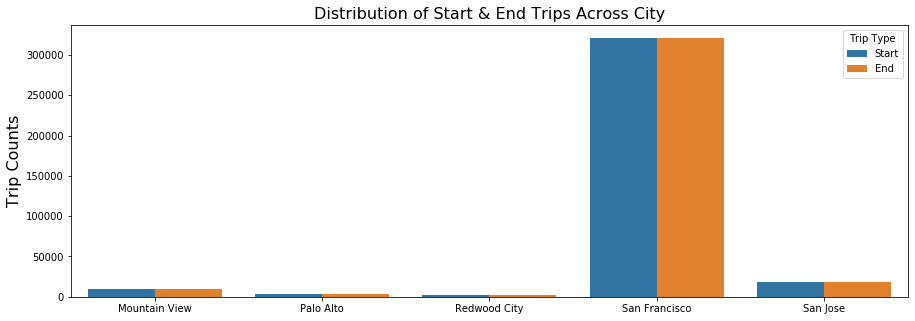

In [32]:
plt.figure(figsize = (15,5))
g = sns.barplot(x = 'index',y='Trip ID',
                hue="Trip Type",data = trip_total)
g.set_title('Distribution of Start & End Trips Across City',fontsize=16)
g.set_xlabel('',fontsize=16)
g.set_ylabel('Trip Counts',fontsize=16)

Distribution of Subscriber Type Across City (Start Trips)

In [33]:
start_sub = trip.groupby(['Start Station','Subscriber Type']).count().reset_index()

Text(0, 0.5, 'Subscriber Counts')

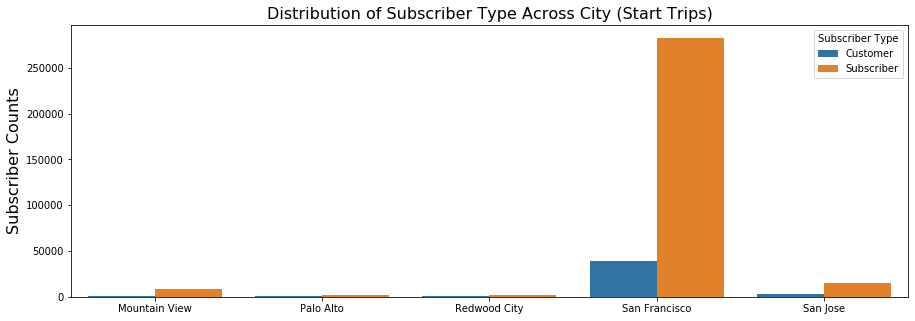

In [34]:
plt.figure(figsize = (15,5))
g = sns.barplot(x = 'Start Station',y='Trip ID',
                hue="Subscriber Type",data = start_sub)
g.set_title('Distribution of Subscriber Type Across City (Start Trips)',fontsize=16)
g.set_xlabel('',fontsize=16)
g.set_ylabel('Subscriber Counts',fontsize=16)

plor correlation matrix heatmap for weather data

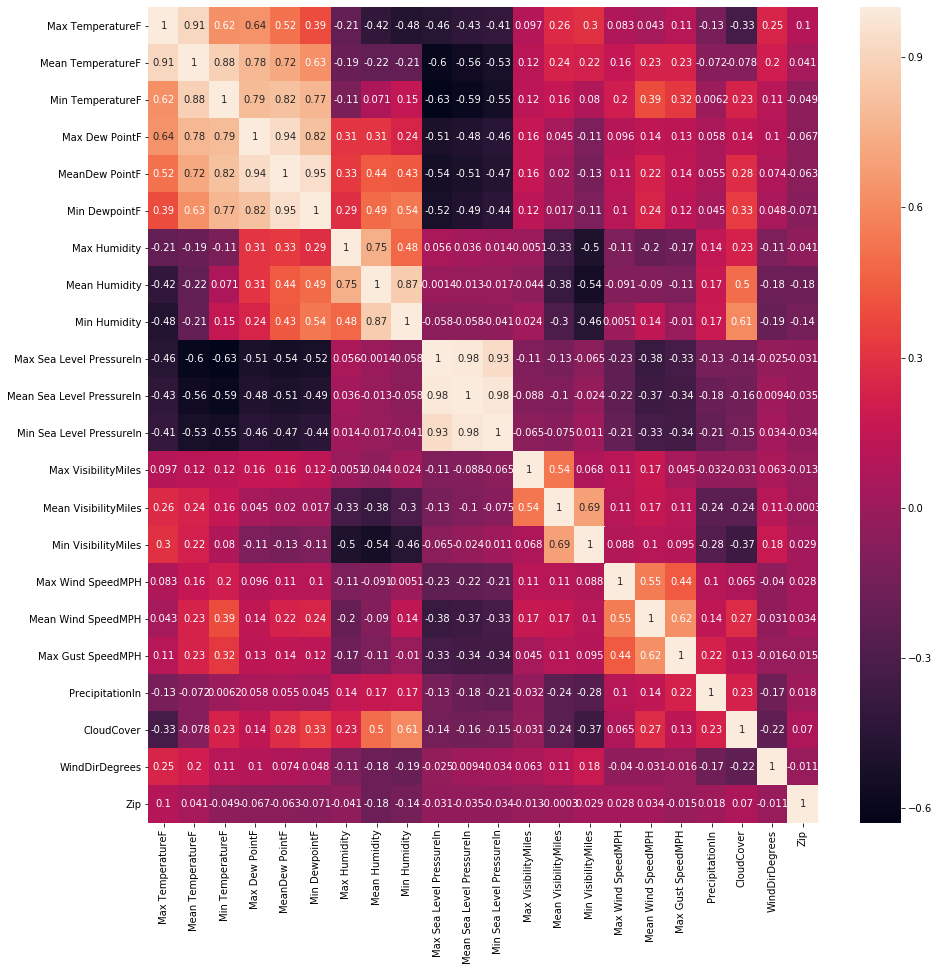

In [35]:
plt.figure(figsize = (15,15))
sns.heatmap(weather.corr(),annot=True)

# Modeling

In [36]:
#Lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [78]:
data_Y.head()

,Start Station,year_x,mon_x,day_x,outhour,Netrate,ID
0,Mountain View,2014,9,1,7,0,2014-9-1-7
1,San Francisco,2014,9,1,7,1,2014-9-1-7
2,San Jose,2014,9,1,7,1,2014-9-1-7
3,Mountain View,2014,9,1,10,0,2014-9-1-10
4,Mountain View,2014,9,1,10,28,2014-9-1-10


In [94]:
#weather.head()
#data_Y['year_x'].astype(str)+'-'+data_Y['mon_x'].astype(str)+'-'+data_Y['day_x'].astype(str)+'-'+x['day'].astype(str)
#data_Y['ID'] = data_Y['ID'].str.split('-')
#data_Y.head()
#pd.to_datetime(data_Y['ID'],format='"%Y-%m-%d')

,Start Station,year_x,mon_x,day_x,outhour,Netrate,ID
0,Mountain View,2014,9,1,7,0,NaN
1,San Francisco,2014,9,1,7,1,NaN
2,San Jose,2014,9,1,7,1,NaN
3,Mountain View,2014,9,1,10,0,NaN
4,Mountain View,2014,9,1,10,28,NaN


In [46]:
#lasso
lasso= Lasso()
paramters={'alpha':[0.1,0.4,1]}
s=GridSearchCV(lasso, paramters,scoring='neg_mean_squared_error',cv=5)
y=data_Y['Netrate']
x=data_Y.drop('Netrate',axis=1)
s.fit(x,y)
print(s.best_params_)
print(-s.best_score_)
rmse=(-s.best_score_)**(1/2)
print('RMSE_lasso')
print(rmse)

{'alpha': 1}
14.54498455100038
RMSE_lasso
3.813788739691854


result:
MSE = 14.54498455100038 ; 
RMSE = 3.813788739691854

In [45]:
#Ridge
from sklearn.linear_model import Ridge
ridge=Ridge()
paramters={'alpha':[0.1,0.4,1]}
k=GridSearchCV(ridge, paramters,scoring='neg_mean_squared_error',cv=5)
k.fit(x,y)
print(k.best_params_)
print(-k.best_score_)
print('RMSE_ridge')
print(rmse)

{'alpha': 1}
14.72440500469826
RMSE_ridge
3.813788739691854


# Improvements

The project came with a clear data mining question for predictive modeling. However, I spent majority of the time cleaning the data, to calculate the target variable Y and fill in empty values in the weather data. If given more possible time, I would strengthen the project result in several steps listed below:
1.	Construct more predictor values for predictive modeling. For example, I can another X column indicating whether the corresponding is a weekend, assuming that the bike rental volume would be different in weekdays and weekends. Similarly, I also wish to construct a X column indicating whether the hour of the day is in rush hours. 
2.	Although lasso returned an adequate RMSE value, I would improve the modeling process by applying grid-search to fine-tune model parameters and expanding the training models to other possible modeling algorithms. 
3.	So far, my exploratory data analysis only restricts to predictors, I would expand my EDA by associating the constructed target variable with predictors.